# Imports

In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.functions import CorrClass as cs
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 12,40

cs = cs()

# Set rules

In [2]:
MIN_ADD = datetime.timedelta(seconds = 60)
HOUR_ADD = 60 * MIN_ADD
DAY_ADD = HOUR_ADD * 24 

# Get data

In [3]:
dfMarketData = pd.read_csv('WDODATA.csv','\t')
dfMarketData.columns = ['Date','Time','Open','High','Low','Close','TickVol','Vol','Spread']
dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
dfMarketData = dfMarketData.set_index('Datetime')
dfMarketData = dfMarketData.sort_index()

In [4]:
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsFromTo = pd.read_csv('EventsFromTo.csv')
dfEventsFromTo=dfEventsFromTo.set_index('EventID').T
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue']/dfEventsData['PreviousValue']-1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData = dfEventsData.loc[dfEventsData['ReleaseTime'] > min(dfMarketData.index),:]
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('ReleaseTime')
dfEventsData = dfEventsData.sort_index()

# Split train/test

In [5]:
dfEventsDataTrain=dfEventsData[dfEventsData.index<=datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfEventsDataTest=dfEventsData[dfEventsData.index>datetime.datetime.combine(dfEventsData.iloc[int(.7*len(dfEventsData)),:]['Date'], datetime.datetime.min.time())]
dfMarketDataTrain=dfMarketData.loc[dfMarketData.index<datetime.datetime.combine(max(dfEventsDataTrain.index).date(), datetime.datetime.min.time())+DAY_ADD]
dfMarketDataTest=dfMarketData[dfMarketData.index>=datetime.datetime.combine(max(dfMarketDataTrain.index).date(), datetime.datetime.min.time())]

# Calculate variation after releases

In [6]:
def variationRatio(
    dfEventsData,
    dfMarketData
) -> pd.DataFrame():
    df = pd.DataFrame()
    for idx, release in dfEventsData.iterrows():
        mktdata_on_release = idx
        mktdata_after_release = mktdata_on_release + MIN_ADD * 5
        mktdata_pre_release = mktdata_on_release - MIN_ADD * 5
        df_mktdata_release = dfMarketData[(dfMarketData.index >= mktdata_on_release) & (dfMarketData.index <= mktdata_after_release)]
        df_mktdata_pre_release = dfMarketData[(dfMarketData.index <= mktdata_on_release) & (dfMarketData.index >= mktdata_pre_release)]
        if not df_mktdata_release.empty and not df_mktdata_pre_release.empty:
            release_price = -1
            try:
                release_price = df_mktdata_release['Open'][mktdata_on_release]
            except:
                try:
                    release_price = df_mktdata_release['Close'][mktdata_on_release - MIN_ADD]
                except:
                    continue
            variation_after_release = max(abs(release_price-max(df_mktdata_release['High'])),abs(release_price-min(df_mktdata_release['Low'])))
            variation_pre_release = max(abs(release_price-max(df_mktdata_pre_release['High'])),abs(release_price-min(df_mktdata_pre_release['Low'])))
            variation_diff = variation_after_release/variation_pre_release-1
            df = df.append(
                {
                    'EventID': dfEventsFromTo[int(release['EventID'])]['EventName'],
                    'Ratio': variation_diff
                }, ignore_index=True 
            )
    dict_data = {}
    for idx, data in df.iterrows():
        if data['EventID'] in dict_data.keys():
            dict_data[data['EventID']].append(data['Ratio'])
        else:
            dict_data[data['EventID']]=[data['Ratio']]
    df = pd.DataFrame.from_dict(dict_data, orient='index')
    df = df.transpose()
    return df

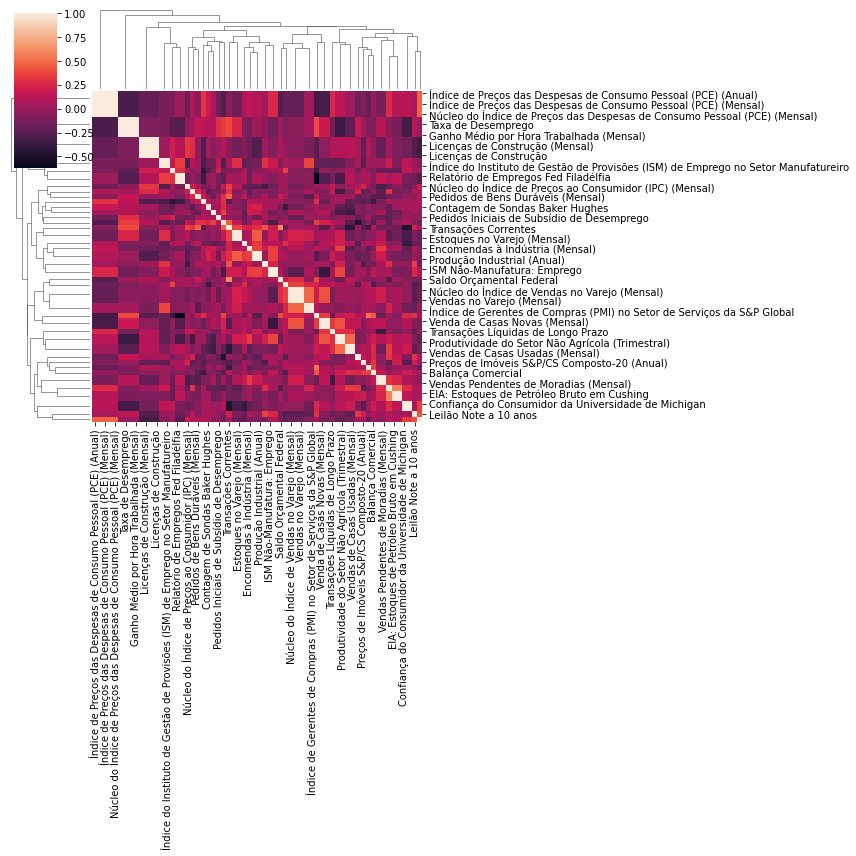

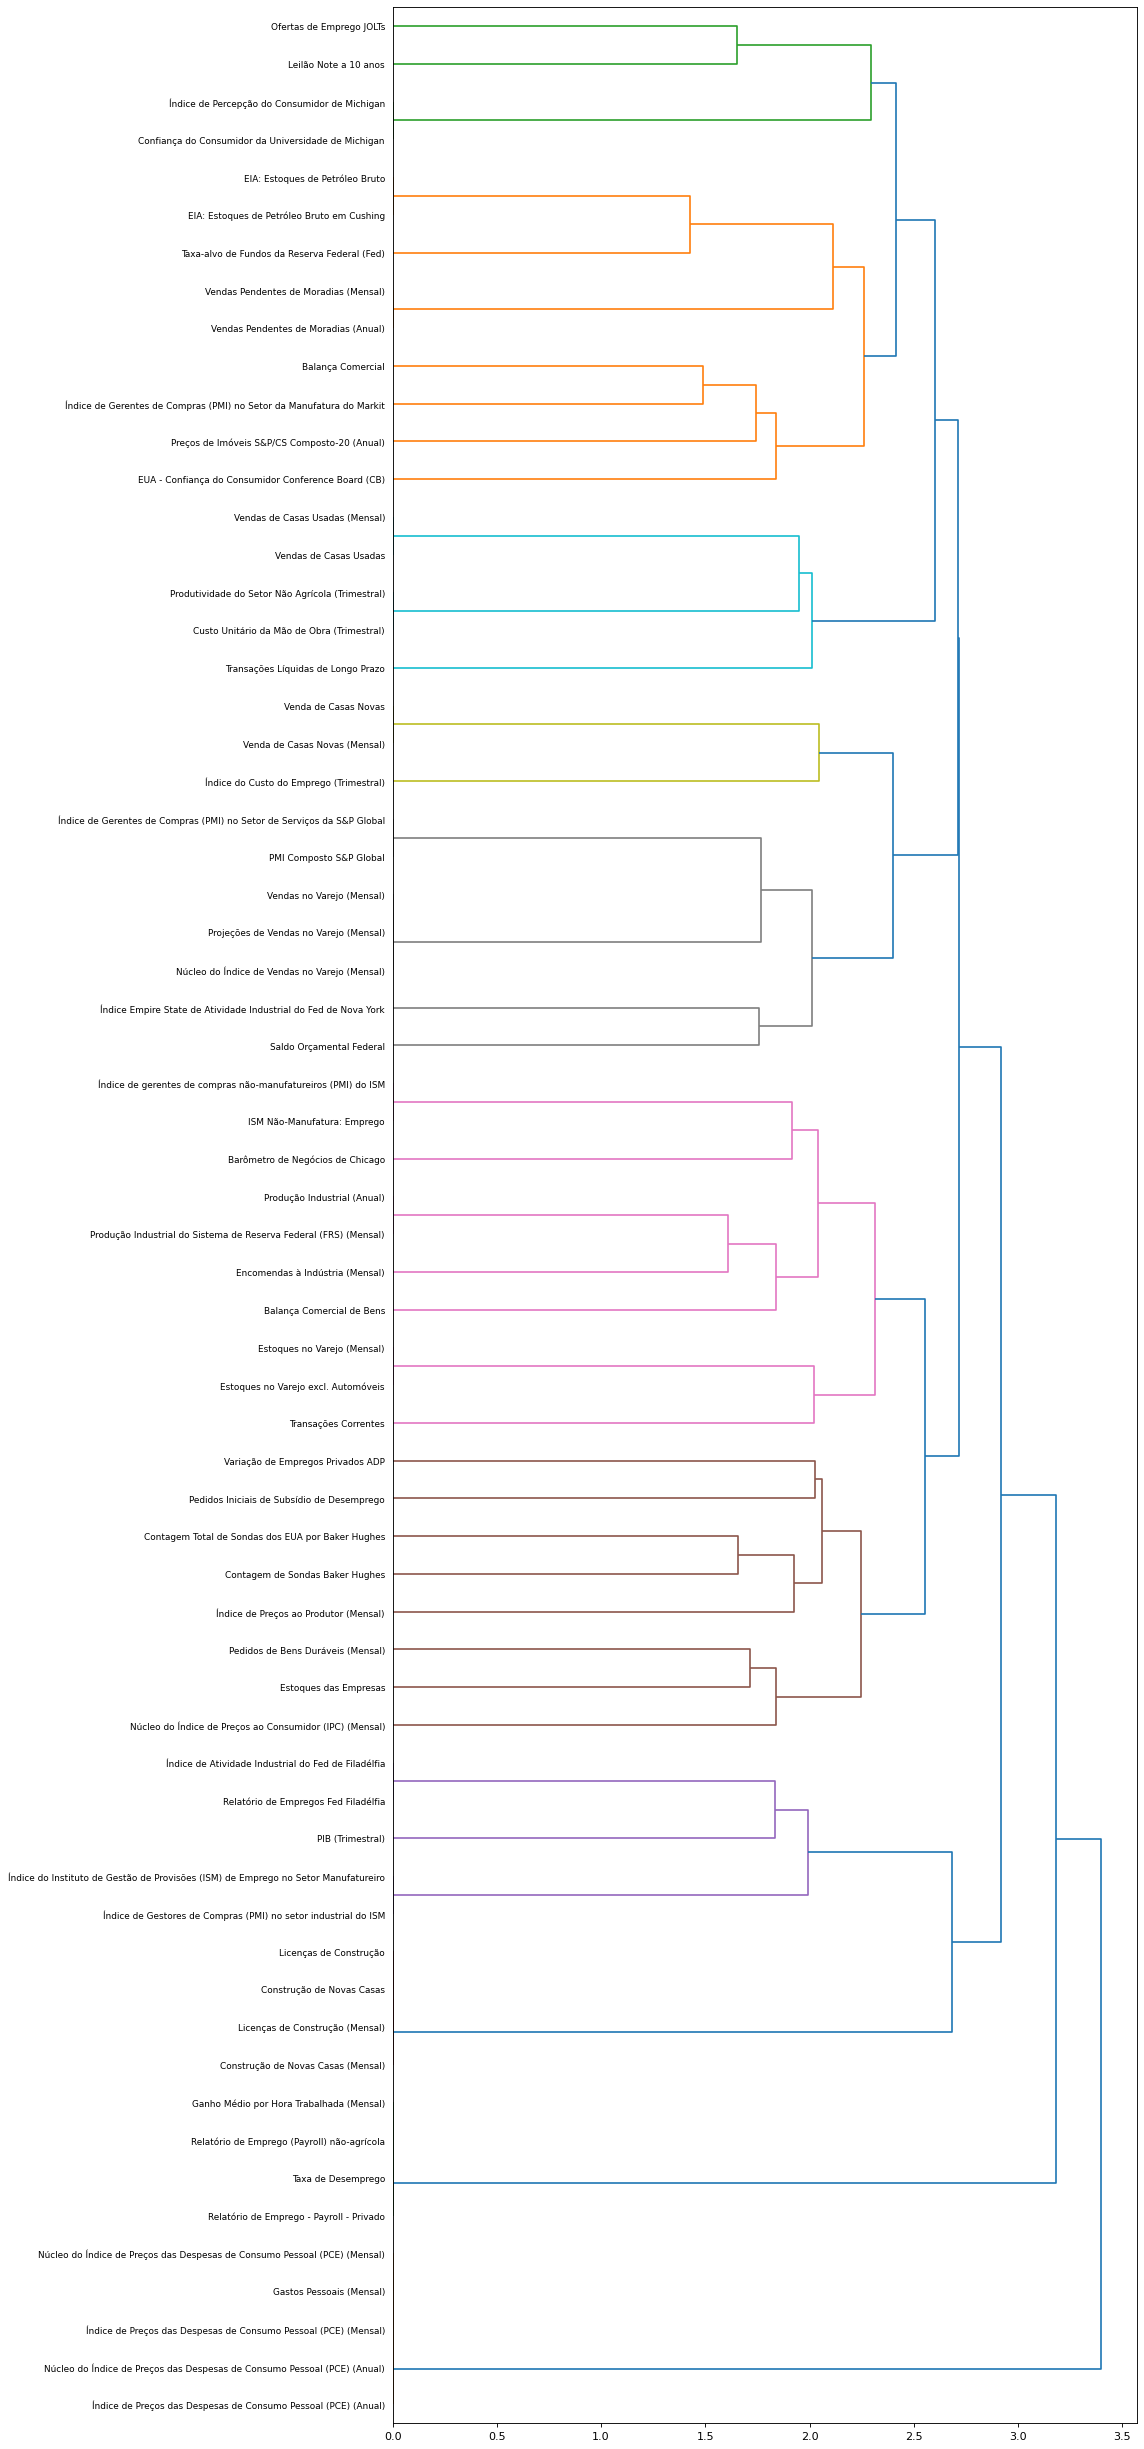

In [7]:
dfTrain = variationRatio(dfEventsData=dfEventsDataTrain,dfMarketData=dfMarketDataTrain)
dendTrain=cs.plot_heatmap_dendogram(dfTrain,'dend_train')

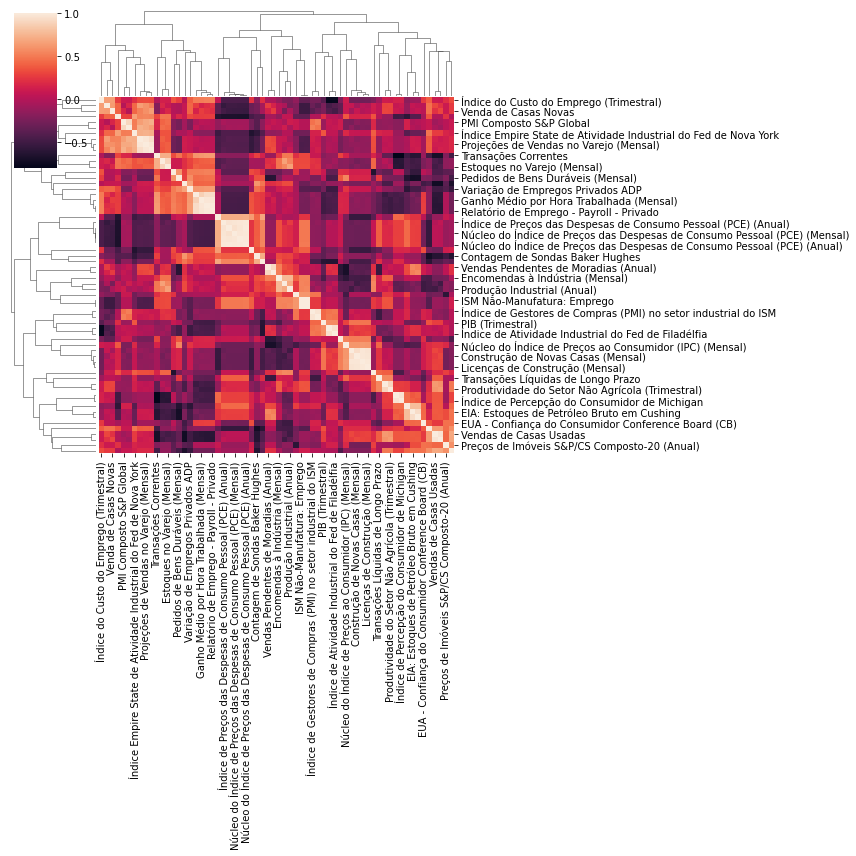

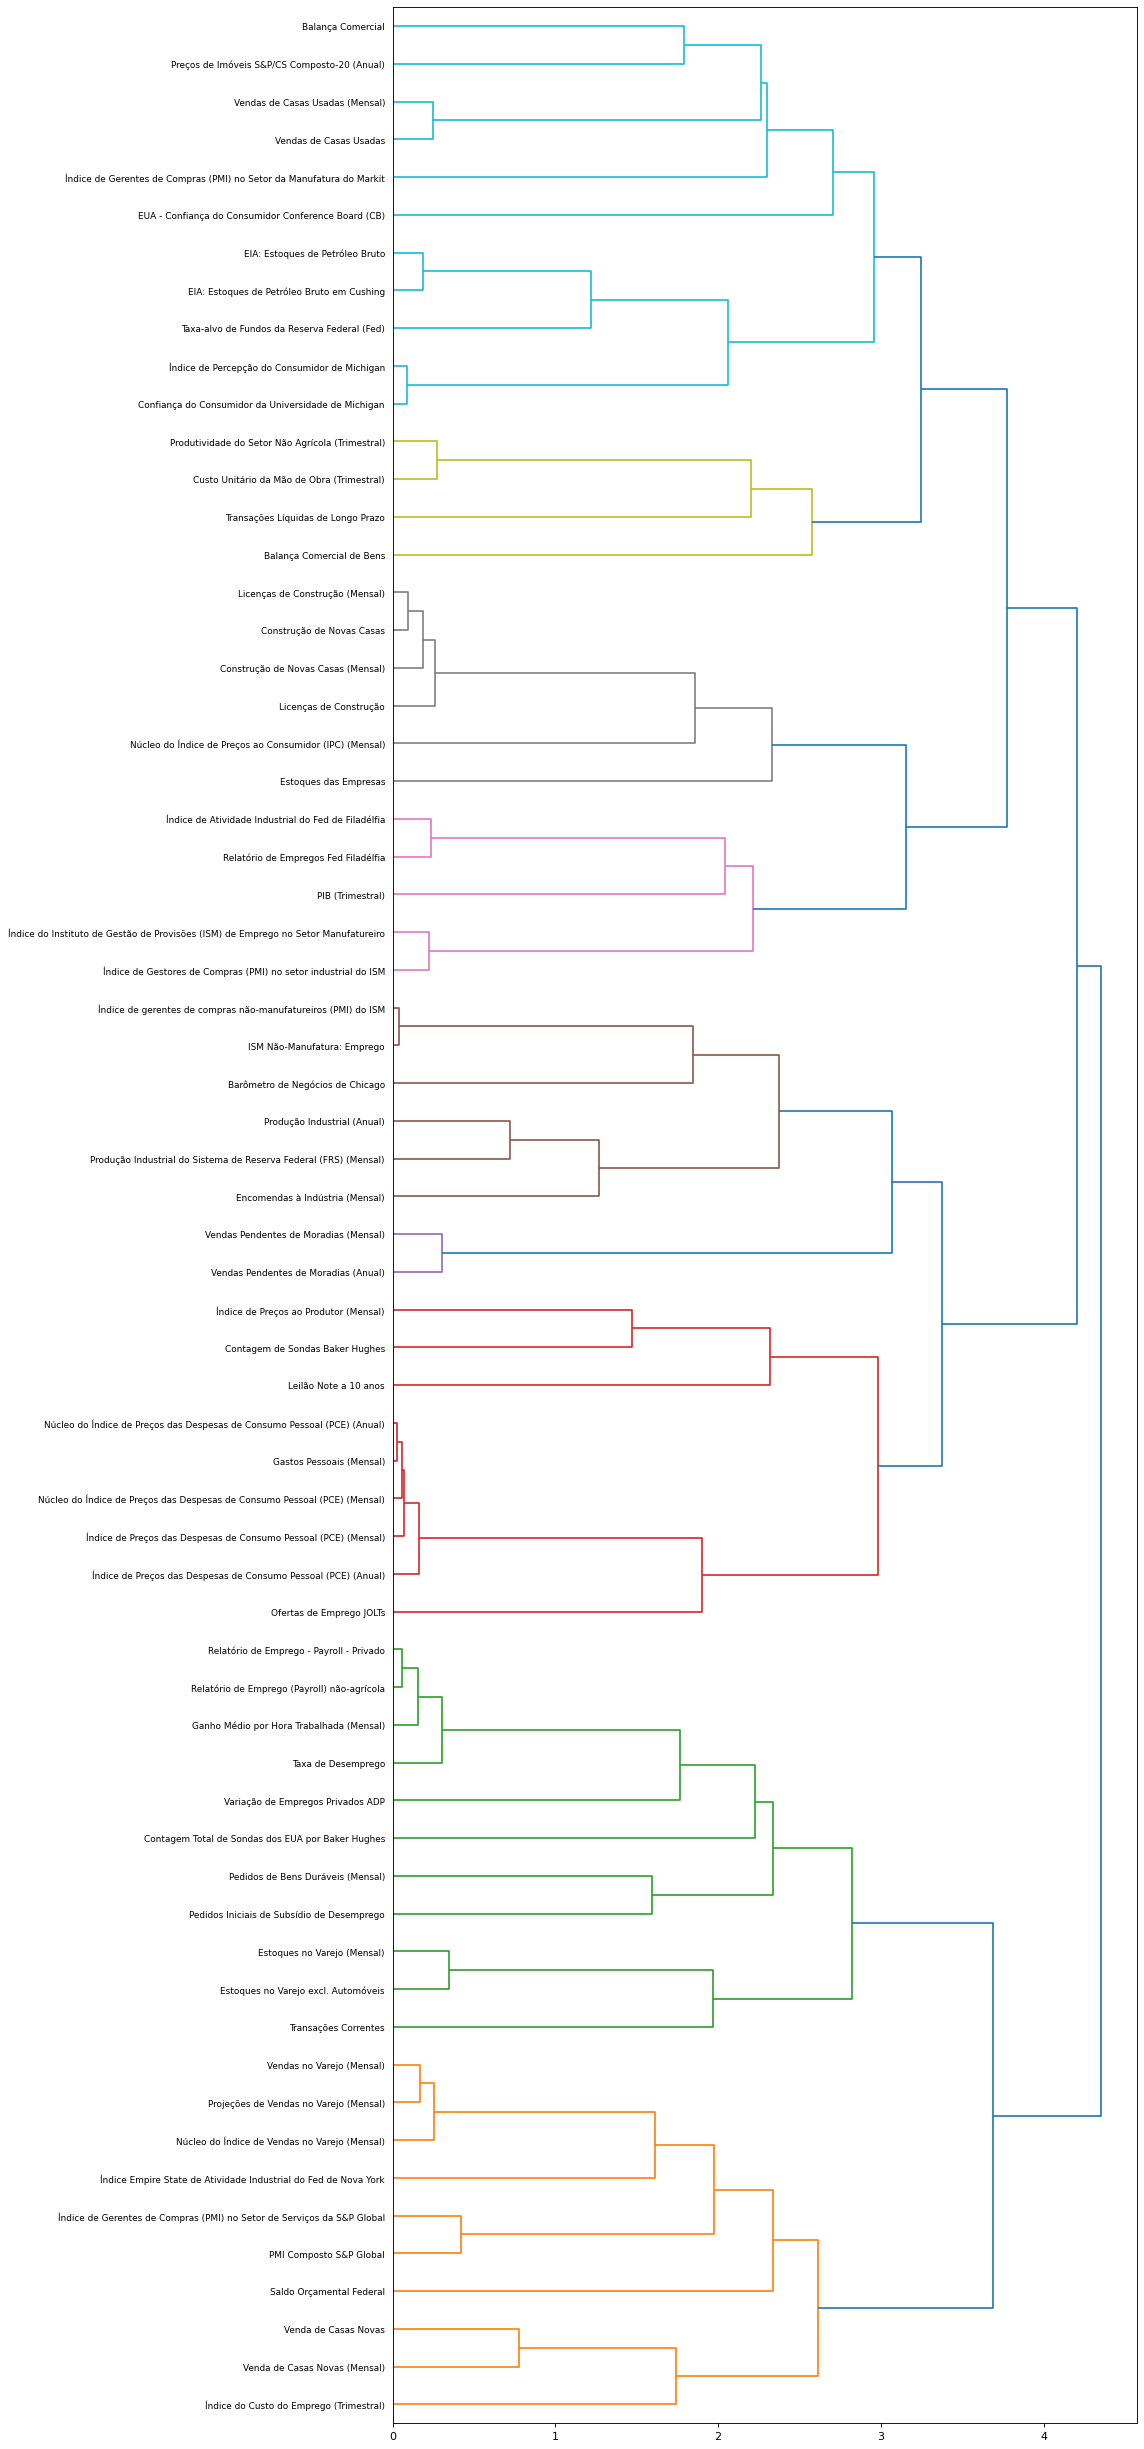

In [8]:
dfTrainDenoised = cs.cov2corr(cs.cleanMatrix(dfTrain))
dendTrainDenoised=cs.plot_heatmap_dendogram(dfTrainDenoised,'dend_train_denoised')

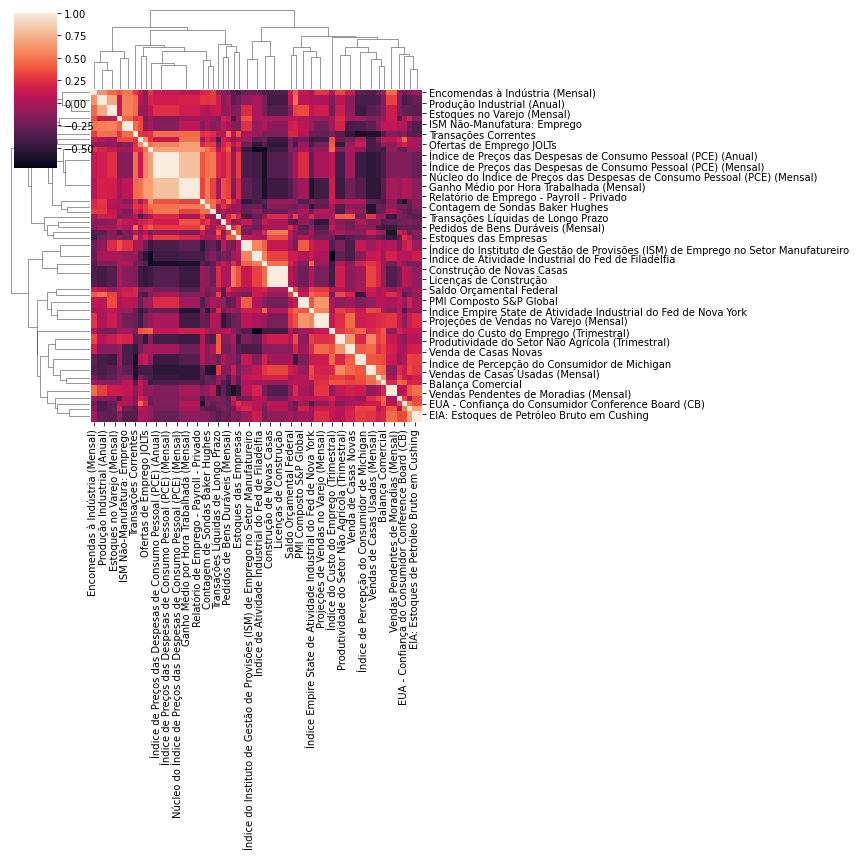

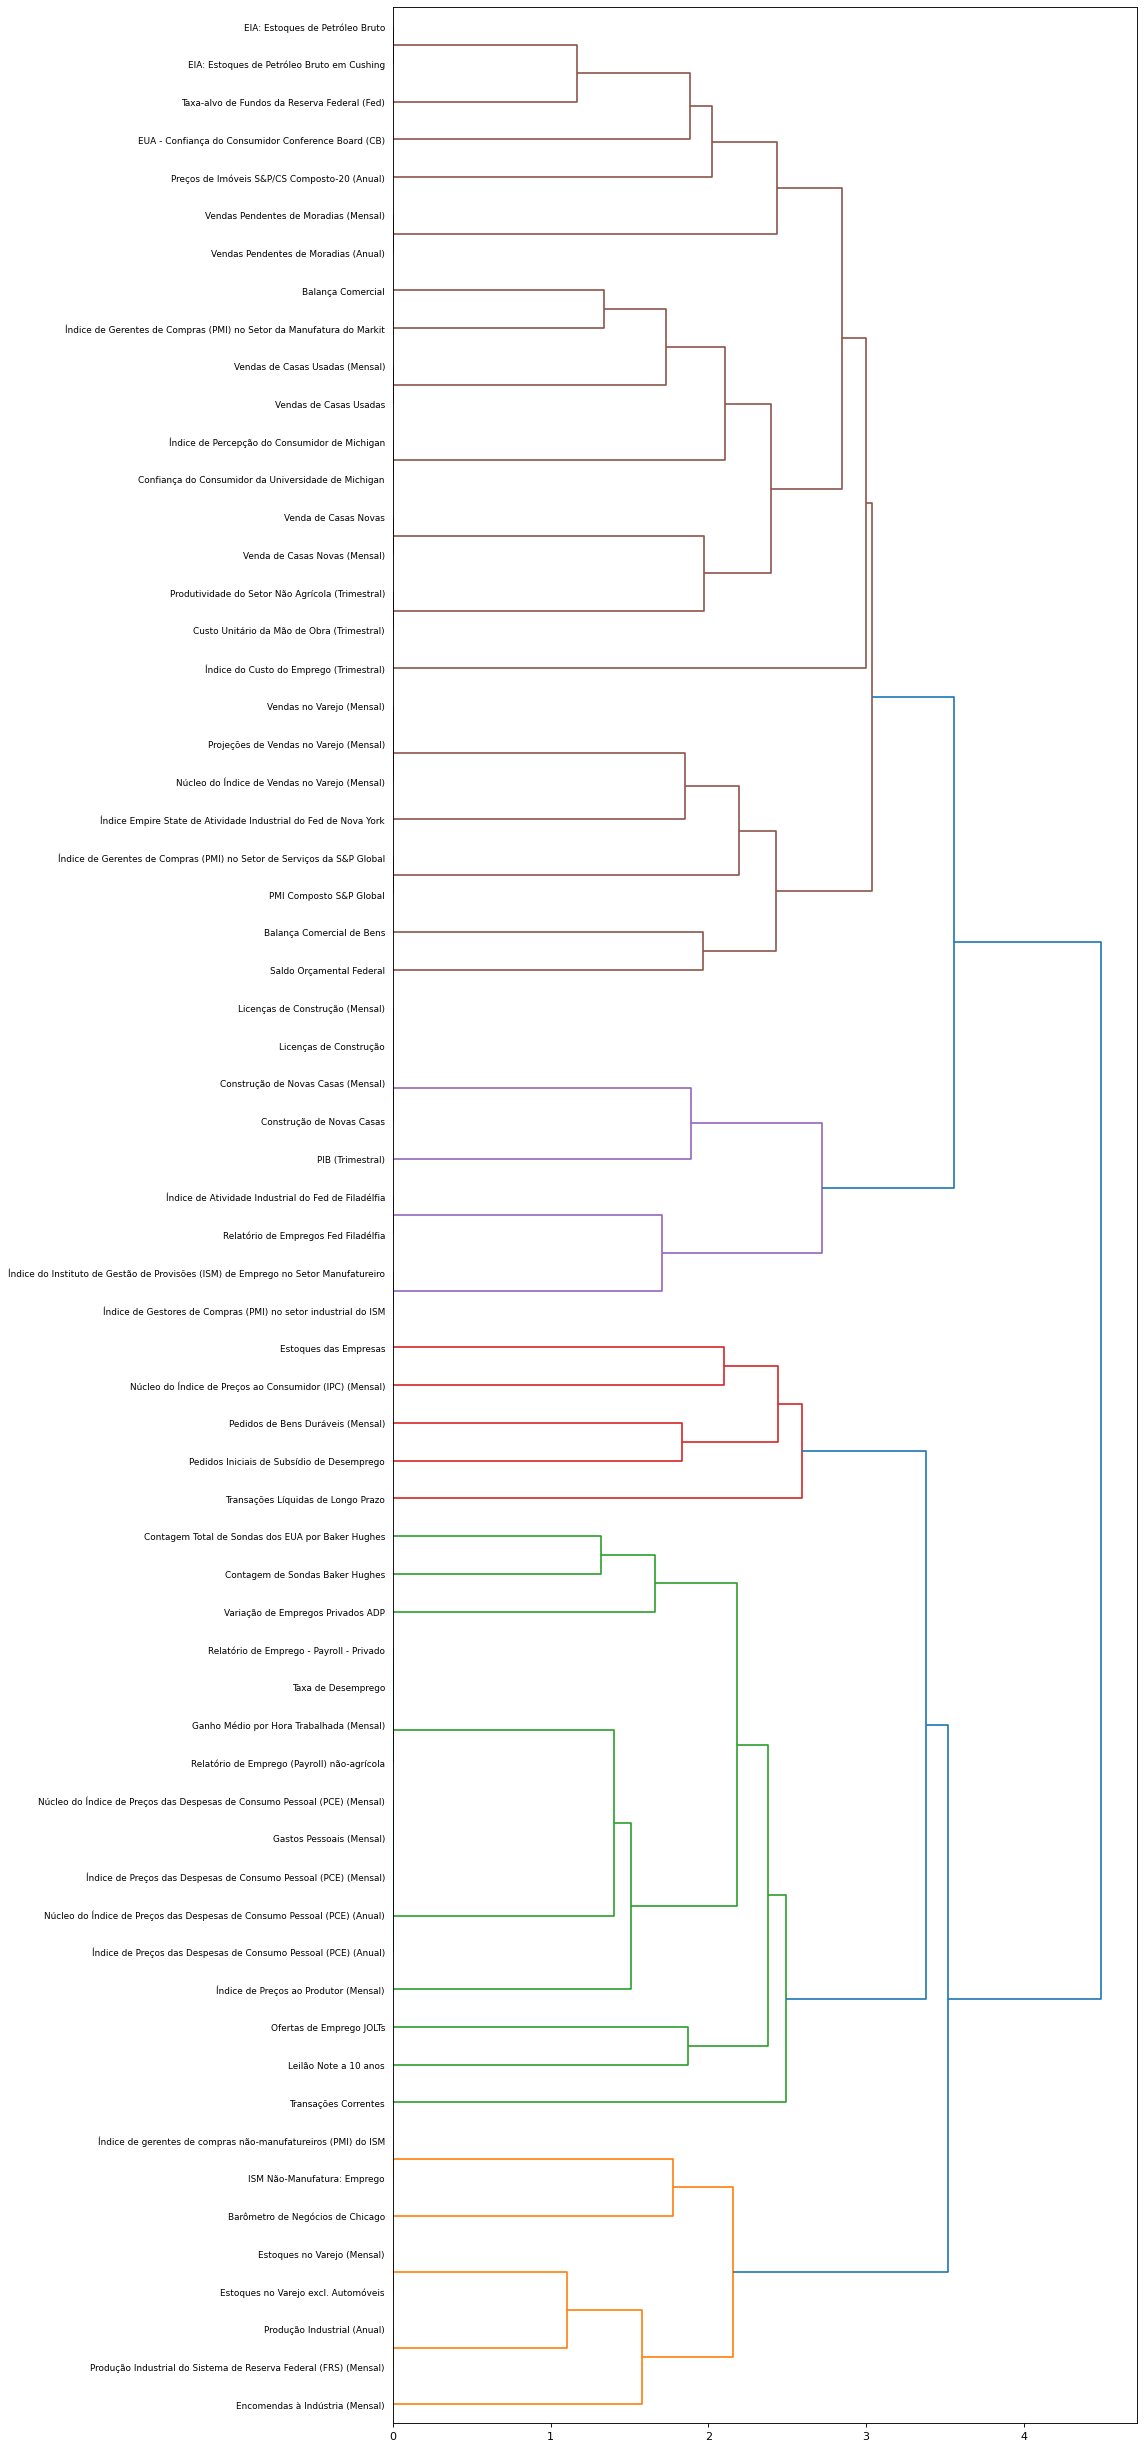

In [9]:
dfTrainDetoned = cs.cov2corr(cs.detonMatrix(dfTrain))
dendTrainDetoned=cs.plot_heatmap_dendogram(dfTrainDetoned,'dend_train_detoned')

In [10]:
chosenDend=dendTrainDenoised

In [11]:
dict_related = {}
idx_group = 1
for i in range(0,len(chosenDend['ivl'])):
    color = chosenDend['leaves_color_list'][i][-1]
    key = f'Group_{color}'
    if key in dict_related.keys():
        dict_related[key].append(chosenDend['ivl'][i])
    else:
        dict_related[key]=[chosenDend['ivl'][i]]

In [12]:
df_groups = pd.DataFrame.from_dict(dict_related, orient='index')
df_groups = df_groups.transpose()

In [13]:
df_groups

,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9
0,Índice do Custo do Emprego (Trimestral),Transações Correntes,Ofertas de Emprego JOLTs,Vendas Pendentes de Moradias (Anual),Encomendas à Indústria (Mensal),Índice de Gestores de Compras (PMI) no setor i...,Estoques das Empresas,Balança Comercial de Bens,Confiança do Consumidor da Universidade de Mic...
1,Venda de Casas Novas (Mensal),Estoques no Varejo excl. Automóveis,Índice de Preços das Despesas de Consumo Pesso...,Vendas Pendentes de Moradias (Mensal),Produção Industrial do Sistema de Reserva Fede...,Índice do Instituto de Gestão de Provisões (IS...,Núcleo do Índice de Preços ao Consumidor (IPC)...,Transações Líquidas de Longo Prazo,Índice de Percepção do Consumidor de Michigan
2,Venda de Casas Novas,Estoques no Varejo (Mensal),Índice de Preços das Despesas de Consumo Pesso...,None,Produção Industrial (Anual),PIB (Trimestral),Licenças de Construção,Custo Unitário da Mão de Obra (Trimestral),Taxa-alvo de Fundos da Reserva Federal (Fed)
3,Saldo Orçamental Federal,Pedidos Iniciais de Subsídio de Desemprego,Núcleo do Índice de Preços das Despesas de Con...,None,Barômetro de Negócios de Chicago,Relatório de Empregos Fed Filadélfia,Construção de Novas Casas (Mensal),Produtividade do Setor Não Agrícola (Trimestral),EIA: Estoques de Petróleo Bruto em Cushing
4,PMI Composto S&P Global,Pedidos de Bens Duráveis (Mensal),Gastos Pessoais (Mensal),None,ISM Não-Manufatura: Emprego,Índice de Atividade Industrial do Fed de Filad...,Construção de Novas Casas,None,EIA: Estoques de Petróleo Bruto
5,Índice de Gerentes de Compras (PMI) no Setor d...,Contagem Total de Sondas dos EUA por Baker Hughes,Núcleo do Índice de Preços das Despesas de Con...,None,Índice de gerentes de compras não-manufatureir...,None,Licenças de Construção (Mensal),None,EUA - Confiança do Consumidor Conference Board...
6,Índice Empire State de Atividade Industrial do...,Variação de Empregos Privados ADP,Leilão Note a 10 anos,None,None,None,None,None,Índice de Gerentes de Compras (PMI) no Setor d...
7,Núcleo do Índice de Vendas no Varejo (Mensal),Taxa de Desemprego,Contagem de Sondas Baker Hughes,None,None,None,None,None,Vendas de Casas Usadas
8,Projeções de Vendas no Varejo (Mensal),Ganho Médio por Hora Trabalhada (Mensal),Índice de Preços ao Produtor (Mensal),None,None,None,None,None,Vendas de Casas Usadas (Mensal)
9,Vendas no Varejo (Mensal),Relatório de Emprego (Payroll) não-agrícola,None,None,None,None,None,None,Preços de Imóveis S&P/CS Composto-20 (Anual)


# Estimate numbers

In [14]:
print(f'Previous lenght {len(dfEventsData)}')
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue']/dfEventsData['PreviousValue']-1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('ReleaseTime')
dfEventsData = dfEventsData.sort_index()
dict_data = {}
for idx, data in dfEventsData.iterrows():
    if dfEventsFromTo[int(data['EventID'])]['EventName'] in dict_data.keys():
        dict_data[dfEventsFromTo[int(data['EventID'])]['EventName']].append(data['ActualValue'])
    else:
        dict_data[dfEventsFromTo[int(data['EventID'])]['EventName']]=[data['ActualValue']]
df = pd.DataFrame.from_dict(dict_data, orient='index')
df = df.transpose()
print(f'Current lenght {len(dfEventsData)}')

Previous lenght 5243
Current lenght 13160


# Modelling

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error

result_dict = {}

for possible_columns in df_groups.columns:
    for i in range(0,len(df_groups[possible_columns])):
        label = df_groups[possible_columns][i]
        if label == None:
            continue
        y = df[label].dropna()
        X = df.drop([elem for i in df_groups.columns for elem in df_groups[i] if i not in [possible_columns] if elem != None], axis=1)
        X = X.iloc[0:len(y)]
        for col in X.columns:
            if X[col].count() < max(X.count()):
                X[col] = X[col].shift(max(X.count())-X[col].count()).fillna(0)
        X = X.shift(1)
        X = X.fillna(0)
        min_len = min(len(X),len(y))
        X = X.iloc[0:min_len]
        y = y.iloc[0:min_len]
        X=X.reset_index(drop=True)
        y=y.reset_index(drop=True)
        # Splitting the datasets into training and testing data.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        vif_features = cs.vif(X)
        result_vif_train=vif_features[vif_features['VIF Factor']<5]
        result_vif_train=result_vif_train.reset_index(drop=True)
        features = result_vif_train['Features']
        if len(features) == 0:
            continue
        X = X[features]
        X_train = X_train[features]
        X_test = X_test[features]
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        # fit/train model
        pipe.fit(X_train, y_train)

        # predict labels
        LR_y_pred = pipe.predict(X_test)

        # metrics
        LR_mse = mean_squared_error(y_test, LR_y_pred)
        LR_rmse = np.sqrt(LR_mse)

        LRresult = {
            'TrainScore': pipe.score(X_train, y_train),
            'TestScore': pipe.score(X_test, y_test)
        }
        elastic = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))
        ])
        
        # fit elasticnet model
        elastic.fit(X_train, y_train)

        # predict labels
        Elastic_y_pred = elastic.predict(X_test)

        # metrics
        Elastic_mse = mean_squared_error(y_test, Elastic_y_pred)
        Elastic_rmse = np.sqrt(Elastic_mse)

        ElasticResult = {
            'TrainScore': elastic.score(X_train, y_train),
            'TestScore': elastic.score(X_test, y_test)
        }
        if not (ElasticResult['TrainScore'] > .6 and ElasticResult['TestScore'] > .5) and (not (LRresult['TrainScore'] > .6 and LRresult['TestScore'] > .5)):
            continue
        result_dict[label] = {
            'ElasticPointer': elastic,
            'ElasticMSE': Elastic_mse,
            'ElasticRMSE': Elastic_rmse,
            'Elastic_y_pred': list(Elastic_y_pred),
            'ElasticScore': ElasticResult['TestScore'],
            'LRPointer': pipe,
            'LRMSE': LR_mse,
            'LRRMSE': LR_rmse,
            'LR_y_pred': list(LR_y_pred),
            'LRScore': LRresult['TestScore'],
            'Features': list(X.columns),
            'y_test': list(y_test)
        }

In [121]:
for key in result_dict.keys():
    pred_values = {}
    for feat in result_dict[key]['Features']:
        pred_values[feat] = df[feat].dropna().iloc[-1]
    pred_value = result_dict[key]['ElasticPointer'].predict([list(pred_values.values())])[0]
    obs = len(result_dict[key]['y_test'])
    elastic_score = result_dict[key]['ElasticScore']
    lr_score = result_dict[key]['LRScore']
    print(f'{key} next pred is {pred_value:.2f}, last was {df[key].dropna().iloc[-1]} ({pred_value/df[key].dropna().iloc[-1]-1:.2f}%). Observations = {obs}. ElasticScore = {elastic_score:.2f}, LRScore = {lr_score:.2f}')

Pedidos Iniciais de Subsídio de Desemprego next pred is 240.88, last was 239.0 (0.01%). Observations = 251. ElasticScore = 0.87, LRScore = 0.87
Índice de Preços das Despesas de Consumo Pessoal (PCE) (Anual) next pred is 4.29, last was 5.0 (-0.14%). Observations = 51. ElasticScore = 0.90, LRScore = 0.96
Contagem de Sondas Baker Hughes next pred is 448.55, last was 590.0 (-0.24%). Observations = 122. ElasticScore = 0.61, LRScore = 0.89
Vendas Pendentes de Moradias (Anual) next pred is -16.44, last was -21.1 (-0.22%). Observations = 39. ElasticScore = 0.64, LRScore = 0.63
Produção Industrial (Anual) next pred is 0.32, last was -0.2 (-2.62%). Observations = 19. ElasticScore = 0.72, LRScore = 0.70
Índice de Gestores de Compras (PMI) no setor industrial do ISM next pred is 46.23, last was 46.3 (-0.00%). Observations = 59. ElasticScore = 0.55, LRScore = 0.54
Índice de Percepção do Consumidor de Michigan next pred is 75.74, last was 62.0 (0.22%). Observations = 108. ElasticScore = 0.72, LRScor

In [125]:
import plotly.express as px

for event_name in result_dict.keys():
    dfToPlot = pd.DataFrame({
        'ElasticNet': result_dict[event_name]['Elastic_y_pred'],
        'LRNet': result_dict[event_name]['LR_y_pred'],
        'Y': result_dict[event_name]['y_test'],
    })

    fig = px.line(dfToPlot, x=dfToPlot.index,y=dfToPlot.columns, title=event_name)
    fig.show();